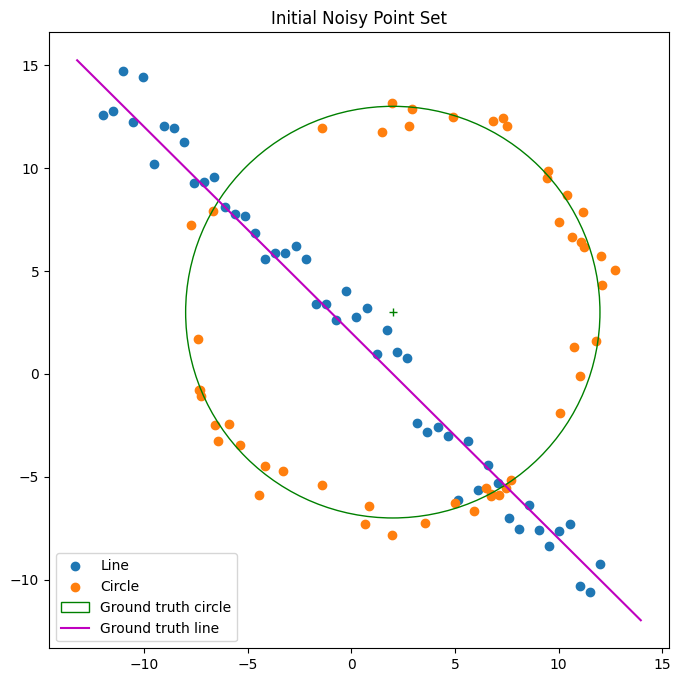

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.8680783758804245e-09
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1743704475712981e-09
            Iterations: 17
            Function evaluations: 79
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.29795313283706e-08
            Iterations: 9
            Function evaluations: 39
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5348561456981385e-08
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.112294377052965e-10
            Iterations: 6
            Fu

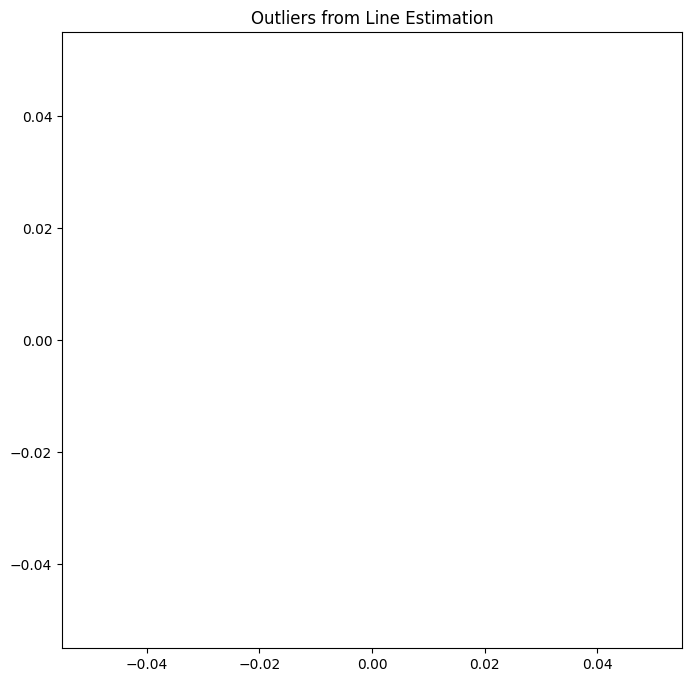

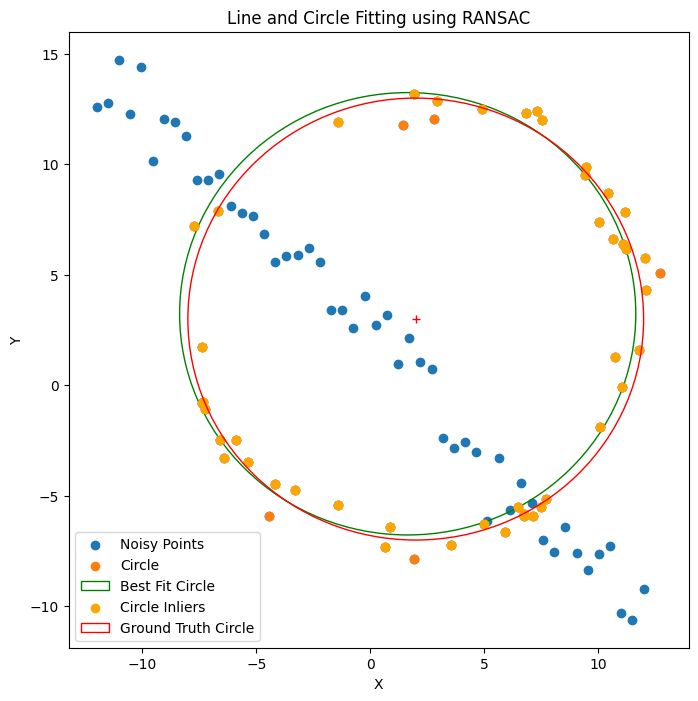

Line model not available


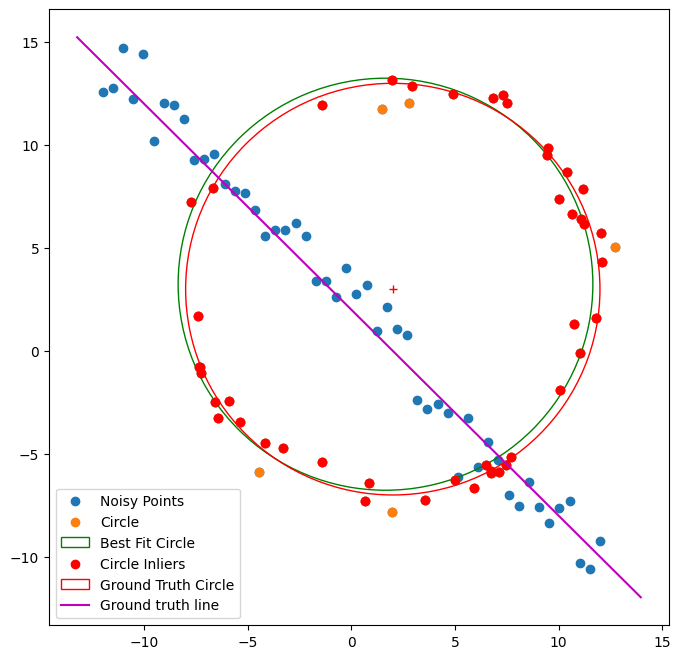

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math
from scipy.optimize import minimize

# Part 2: Generate Noisy Point Set

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plot the initial point set
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.title('Initial Noisy Point Set')
plt.show()

# Part 3: Estimate the Line using RANSAC

def calculate_distance(x1, y1, x2, y2):
    distance_mag = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    a = (x2 - x1) / distance_mag
    b = (y2 - y1) / distance_mag
    d = a * x1 + b * y1
    return a, b, d

def calc_tls(x, indices):
    a = x[0]
    b = x[1]
    d = x[2]
    return np.sum(np.square(a * X[indices, 0] + b * X[indices, 1] - d))

def g(x):
    return x[0] ** 2 + x[1] ** 2 - 1

constraints = ({'type': 'eq', 'fun': g})

def best_fit_line(X, x, t):
    a = x[0]
    b = x[1]
    d = x[2]
    e = np.absolute(a * X[:, 0] + b * X[:, 1] - d)
    return e < t

threshold_value = 1.0
d = 0.5 * N
s = 2

line_inliers = []
circle_inliers = []

max_iters = 100
iters = 0
best_line_model = []
best_error = np.inf
best_sample_line = []
best_inlier_line = []

while iters < max_iters:
    indices = np.random.randint(0, N, 2)
    x0 = np.array([1, 1, 0])
    res = minimize(fun=calc_tls, args=(indices,), x0=x0, tol=1e-6, constraints=constraints, options={'disp': True})
    line_inliers = best_fit_line(X, res.x, threshold_value)

    if line_inliers.sum() > d:
        x0 = res.x
        res = minimize(fun=calc_tls, args=(line_inliers,), x0=x0, tol=1e-6, constraints=constraints, options={'disp': True})
        if res.fun < best_error:
            best_error = res.fun
            best_line_model = res.x
            best_sample_line = X[indices, :]
            best_inlier_line = line_inliers
            res_only_with_sample = x0
            print("Best line model: ", best_line_model)
            print("Best error: ", best_error)
            print("Best sample: ", best_sample_line)
            print("Best inlier: ", best_inlier_line)
            print("Number of inliers: ", best_inlier_line.sum())
            print("Number of outliers: ", N - best_inlier_line.sum())
            print("Number of iterations: ", iters)
            print("------------------------------------------------------")

    iters += 1

print("The Best Line model got: ", best_line_model)

# Part 4: Fit Circle to Remnant

def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    r = np.sqrt((x1 - Ux)**2 + (y1 - Uy)**2)
    return Ux, Uy, r

def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]
        x, y, r = calculate_circle_parameters(sample_points)
        radial_errors = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)
        inliers = np.where(radial_errors < error_threshold)[0]
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (x, y, r)

    return best_circle, best_inliers

num_iterations_circle = 1000
error_threshold_circle = 0.85
min_consensus_circle = 40

best_circle, circle_inliers = fit_circle_ransac(X_circ, num_iterations_circle, error_threshold_circle, min_consensus_circle)

# Part 5: Visualize Line Outliers

outliers_indices = np.where(np.logical_not(best_inlier_line))[0]
outliers_data = X[outliers_indices, :]

plt.subplots(figsize=(8, 8))
plt.scatter(outliers_data[:, 0], outliers_data[:, 1])
plt.title('Outliers from Line Estimation')
plt.show()

# Part 6: Visualize Line and Circle Fitting

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

if best_circle is not None:  # Check if the circle was successfully estimated
    x_circle, y_circle, r_circle = best_circle
    circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(circle)
    ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='orange', label='Circle Inliers')
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()

# Part 7: Visualize Line, Circle, and Inliers

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

x_circle, y_circle, r_circle = best_circle
circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
ax.add_patch(circle)
ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='red', label='Circle Inliers')
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')

x_min, x_max = ax.get_xlim()
x_ = np.linspace(x_min, x_max, 100)  # Create a range of x values
if len(best_line_model) == 2:
    y_ = (-best_line_model[0] * x_ + best_line_model[1])  # Fit line equation (y = ax + b)
    plt.plot(x_, y_, label='RANSAC line')
else:
    print("Line model not available")

x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

